# Fine-tuning Techniques for Transformer Models: A Comparative Study

This notebook implements and compares four different fine-tuning techniques for transformer-based models using a sentiment classification task on the IMDb dataset:

1. Full Fine-tuning
2. LoRA (Low-Rank Adaptation)
3. QLoRA (Quantized Low-Rank Adaptation)
4. Adapter Tuning (IA3)

We'll compare these methods based on:
- Accuracy
- Number of trainable parameters
- Training time
- GPU memory usage

## 1. Environment Setup

First, let's set up our environment and install all necessary libraries.

In [1]:
# Check available GPU
!nvidia-smi

Fri Apr 25 12:17:32 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.247.01             Driver Version: 535.247.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:35:00.0 Off |                    0 |
| N/A   38C    P8              16W /  72W |      0MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Install required libraries
!pip uninstall -y transformers datasets evaluate accelerate peft bitsandbytes
!pip install -q transformers datasets evaluate accelerate peft bitsandbytes

Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Successfully uninstalled transformers-4.51.3
Found existing installation: datasets 3.5.0
Uninstalling datasets-3.5.0:
  Successfully uninstalled datasets-3.5.0
Found existing installation: evaluate 0.4.3
Uninstalling evaluate-0.4.3:
  Successfully uninstalled evaluate-0.4.3
Found existing installation: accelerate 1.4.0
Uninstalling accelerate-1.4.0:
  Successfully uninstalled accelerate-1.4.0
Found existing installation: peft 0.15.2
Uninstalling peft-0.15.2:
  Successfully uninstalled peft-0.15.2
Found existing installation: bitsandbytes 0.45.5
Uninstalling bitsandbytes-0.45.5:
  Successfully uninstalled bitsandbytes-0.45.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth-zoo 2025.2.7 requires protobuf<4.0.0, but you have protobuf 5.29.4 which is incompatible.


In [1]:
# Import required libraries
import os
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from peft import (
    get_peft_model,
    LoraConfig,
    TaskType,
    IA3Config,
    prepare_model_for_kbit_training
)
import evaluate
import wandb

## 2. Data Preprocessing

Let's load and preprocess the IMDb dataset for sentiment classification.

In [2]:
# Load IMDb dataset
imdb_dataset = load_dataset("imdb")
print(imdb_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [3]:
# Display a few examples
print("Example from training set:")
print(imdb_dataset["train"][0])

Example from training set:
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudit

In [4]:
# Initialize tokenizer
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define preprocessing function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

# Tokenize the dataset
tokenized_datasets = imdb_dataset.map(
    tokenize_function,
    batched=True,
    desc="Tokenizing datasets"
)

# Set format for PyTorch
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})


In [5]:
# Select the required subset of data as per assignment requirements
train_dataset_subset = tokenized_datasets["train"].select(range(3000))
eval_dataset_subset = tokenized_datasets["test"].select(range(2000))

print(f"Using {len(train_dataset_subset)} samples for training.")
print(f"Using {len(eval_dataset_subset)} samples for evaluation.")

Using 3000 samples for training.
Using 2000 samples for evaluation.


In [6]:
# Create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create evaluation function
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

## 3. Full Fine-Tuning

We'll start with traditional full fine-tuning, where all parameters of the model are updated.

In [7]:
# Define a function to monitor GPU usage
def get_gpu_memory_stats():
    """Get current GPU memory statistics"""
    if torch.cuda.is_available():
        # No need to synchronize here for current stats
        allocated = torch.cuda.memory_allocated() / 1024**2
        reserved = torch.cuda.memory_reserved() / 1024**2
        return {
            "allocated_MB": allocated,
            "reserved_MB": reserved
        }
    return {"allocated_MB": 0, "reserved_MB": 0}

def cleanup():
    """Free up GPU memory"""
    import gc
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        # No need to synchronize here, empty_cache does it


In [8]:
# Set training arguments for full fine-tuning
training_args = TrainingArguments(
    output_dir="full_fine_tuning_results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="logs",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    run_name="full_fine_tuning",
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    report_to="wandb" # Ensure reports are sent to wandb
)

cleanup() # Initial cleanup before starting
wandb.init(project="PEFT", name="Full-Fine-Tuning", reinit=True)
wandb.config.update(training_args)
wandb.config.update({"model_name": model_name})

# Load the base model
full_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
)

initial_memory = get_gpu_memory_stats()
print(f"GPU memory before training: Allocated: {initial_memory['allocated_MB']:.2f} MB, Reserved: {initial_memory['reserved_MB']:.2f} MB")

# Count trainable parameters
trainable_params_full = sum(p.numel() for p in full_model.parameters() if p.requires_grad)
print(f"Trainable parameters in full fine-tuning: {trainable_params_full}")
wandb.config.update({"trainable_params": trainable_params_full})

# Initialize trainer
trainer_full = Trainer(
    model=full_model,
    args=training_args,
    train_dataset=train_dataset_subset,
    eval_dataset=eval_dataset_subset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Reset peak memory stats before training
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# Start training timer
start_time_full = time.time()

# Train the model
full_train_results = trainer_full.train()

# Calculate training time
training_time_full = time.time() - start_time_full
print(f"Full fine-tuning training time: {training_time_full:.2f} seconds")
wandb.log({"training_time_seconds": training_time_full})

# Evaluate the model
full_eval_results = trainer_full.evaluate()
print("Full fine-tuning evaluation results:", full_eval_results)
wandb.log({"eval_accuracy": full_eval_results["eval_accuracy"]})

# Track peak memory usage during training
peak_memory_allocated_full = torch.cuda.max_memory_allocated() / 1024**2 if torch.cuda.is_available() else 0
peak_memory_reserved_full = torch.cuda.max_memory_reserved() / 1024**2 if torch.cuda.is_available() else 0
print(f"Peak GPU memory during training: Allocated: {peak_memory_allocated_full:.2f} MB, Reserved: {peak_memory_reserved_full:.2f} MB")
wandb.log({"peak_allocated_memory_MB": peak_memory_allocated_full, "peak_reserved_memory_MB": peak_memory_reserved_full})

# cleanup
del full_model, trainer_full # Explicitly delete objects
cleanup()
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ammar-90123 (ammar-90) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_4024/1830428827.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_full = Trainer(


GPU memory before training: Allocated: 0.00 MB, Reserved: 0.00 MB
Trainable parameters in full fine-tuning: 124647170


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000200,0.000041,1.000000
2,0.000000,0.000011,1.000000
3,0.000000,0.000008,1.000000


Full fine-tuning training time: 593.08 seconds


Full fine-tuning evaluation results: {'eval_loss': 8.402252205996774e-06, 'eval_accuracy': 1.0, 'eval_runtime': 28.2739, 'eval_samples_per_second': 70.737, 'eval_steps_per_second': 4.421, 'epoch': 3.0}
Peak GPU memory during training: Allocated: 2423.55 MB, Reserved: 2560.00 MB


eval/accuracy,▁▁▁▁
eval/loss,█▂▁▁
eval/runtime,▁█▂▅
eval/samples_per_second,█▁▇▄
eval/steps_per_second,█▁▇▄
eval_accuracy,▁
peak_allocated_memory_MB,▁
peak_reserved_memory_MB,▁
train/epoch,▁▂▂▃▃▄▄▅▅▆▆▇████
train/global_step,▁▂▂▃▃▄▄▅▅▆▆▇███████
train/grad_norm,█▃▂▁▁▁▁▁▁▁▁


## 4. LoRA Fine-Tuning

Now, let's implement LoRA (Low-Rank Adaptation), which adds trainable low-rank matrices to certain layers of the model while keeping most parameters frozen.

In [9]:
cleanup() # Cleanup before starting LoRA
# Load the base model for LoRA
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
)

# Define LoRA Configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "key", "value"],
)

wandb.init(project="PEFT", name="LoRA-Fine-Tuning", reinit=True)
wandb.config.update(training_args)
wandb.config.update({"model_name": model_name, "lora_r": lora_config.r, "lora_alpha": lora_config.lora_alpha})

# Create LoRA model
lora_model = get_peft_model(base_model, lora_config)
print(lora_model.print_trainable_parameters())

# Track memory before training
initial_memory_lora = get_gpu_memory_stats()
print(f"GPU memory before LoRA fine-tuning allocated: {initial_memory_lora['allocated_MB']:.2f} MB, reserved: {initial_memory_lora['reserved_MB']:.2f} MB")

# Count trainable parameters
trainable_params_lora = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
print(f"Trainable parameters in LoRA fine-tuning: {trainable_params_lora}")
wandb.config.update({"trainable_params": trainable_params_lora})

# Initialize trainer
trainer_lora = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset_subset,
    eval_dataset=eval_dataset_subset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Reset peak memory stats before training
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# Start training timer
start_time_lora = time.time()

# Train the model
lora_train_results = trainer_lora.train()

# Calculate training time
training_time_lora = time.time() - start_time_lora
print(f"LoRA fine-tuning training time: {training_time_lora:.2f} seconds")
wandb.log({"training_time_seconds": training_time_lora})

# Evaluate the model
lora_eval_results = trainer_lora.evaluate()
print("LoRA fine-tuning evaluation results:", lora_eval_results)
wandb.log({"eval_accuracy": lora_eval_results["eval_accuracy"]})

# Track peak memory usage during training
peak_memory_allocated_lora = torch.cuda.max_memory_allocated() / 1024**2 if torch.cuda.is_available() else 0
peak_memory_reserved_lora = torch.cuda.max_memory_reserved() / 1024**2 if torch.cuda.is_available() else 0
print(f"Peak GPU memory during LoRA training: Allocated: {peak_memory_allocated_lora:.2f} MB, Reserved: {peak_memory_reserved_lora:.2f} MB")
wandb.log({"peak_allocated_memory_MB": peak_memory_allocated_lora, "peak_reserved_memory_MB": peak_memory_reserved_lora})

# cleanup
del base_model, lora_model, trainer_lora # Explicitly delete objects
cleanup()
wandb.finish()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,034,498 || all params: 125,681,668 || trainable%: 0.8231
None
GPU memory before LoRA fine-tuning allocated: 16.25 MB, reserved: 24.00 MB
Trainable parameters in LoRA fine-tuning: 1034498


/tmp/ipykernel_4024/2152564505.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.004200,0.000081,1.000000
2,0.000100,0.000009,1.000000
3,0.000000,0.000007,1.000000


LoRA fine-tuning training time: 500.75 seconds


LoRA fine-tuning evaluation results: {'eval_loss': 6.756989478162723e-06, 'eval_accuracy': 1.0, 'eval_runtime': 29.6792, 'eval_samples_per_second': 67.387, 'eval_steps_per_second': 4.212, 'epoch': 3.0}
Peak GPU memory during LoRA training: Allocated: 926.40 MB, Reserved: 1214.00 MB


eval/accuracy,▁▁▁▁
eval/loss,█▁▁▁
eval/runtime,▁▄█▅
eval/samples_per_second,█▅▁▄
eval/steps_per_second,█▅▁▄
eval_accuracy,▁
peak_allocated_memory_MB,▁
peak_reserved_memory_MB,▁
train/epoch,▁▂▂▃▃▄▄▅▅▆▆▇████
train/global_step,▁▂▂▃▃▄▄▅▅▆▆▇███████
train/grad_norm,█▂▁▁▁▁▁▁▁▁▁


## 5. QLoRA Fine-Tuning

Next, let's implement QLoRA, which combines quantization with LoRA to further reduce memory usage.

In [14]:
cleanup() # Cleanup before starting QLoRA
# Load the base model with 4-bit quantization
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# Load the quantized model
qlora_base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    quantization_config=bnb_config,
    device_map="auto" # Automatically handle device placement
)

wandb.init(project="PEFT", name="QLoRA-Fine-Tuning", reinit=True)
wandb.config.update(training_args)
wandb.config.update({"model_name": model_name, "quantization": "4-bit NF4"})

# Prepare model for k-bit training
# No need to manually move to GPU if device_map="auto" is used
qlora_base_model = prepare_model_for_kbit_training(qlora_base_model)

# Replace the (4‑bit) classification head with a fresh fp32 head to avoid BitsAndBytes assertions
from transformers.models.roberta.modeling_roberta import RobertaClassificationHead
import torch.nn as nn

# grab device
device = next(qlora_base_model.parameters()).device

# save old head weights
orig_state = qlora_base_model.classifier.state_dict()

# create new fp32 head and load weights
new_head = RobertaClassificationHead(qlora_base_model.config).to(device).float()
new_head.load_state_dict(orig_state)
qlora_base_model.classifier = new_head

# make sure it’s trainable
for param in qlora_base_model.classifier.parameters():
    param.requires_grad = True


# Define LoRA Configuration for QLoRA
qlora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "key", "value"],
)
wandb.config.update({"lora_r": qlora_config.r, "lora_alpha": qlora_config.lora_alpha})

# Create QLoRA model
qlora_model = get_peft_model(qlora_base_model, qlora_config)
print(qlora_model.print_trainable_parameters())

# Track memory before training
initial_memory_qlora = get_gpu_memory_stats()
print(f"GPU memory before QLoRA fine-tuning allocated: {initial_memory_qlora['allocated_MB']:.2f} MB, reserved: {initial_memory_qlora['reserved_MB']:.2f} MB")

# Count trainable parameters
trainable_params_qlora = sum(p.numel() for p in qlora_model.parameters() if p.requires_grad)
print(f"Trainable parameters in QLoRA fine-tuning: {trainable_params_qlora}")
wandb.config.update({"trainable_params": trainable_params_qlora})

# Initialize trainer
trainer_qlora = Trainer(
    model=qlora_model,
    args=training_args,
    train_dataset=train_dataset_subset,
    eval_dataset=eval_dataset_subset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Reset peak memory stats before training
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# Start training timer
start_time_qlora = time.time()

# Train the model
qlora_train_results = trainer_qlora.train()

# Calculate training time
training_time_qlora = time.time() - start_time_qlora
print(f"QLoRA fine-tuning training time: {training_time_qlora:.2f} seconds")
wandb.log({"training_time_seconds": training_time_qlora})

# Evaluate the model
qlora_eval_results = trainer_qlora.evaluate()
print("QLoRA fine-tuning evaluation results:", qlora_eval_results)
wandb.log({"eval_accuracy": qlora_eval_results["eval_accuracy"]})

# Track peak memory usage during training
peak_memory_allocated_qlora = torch.cuda.max_memory_allocated() / 1024**2 if torch.cuda.is_available() else 0
peak_memory_reserved_qlora = torch.cuda.max_memory_reserved() / 1024**2 if torch.cuda.is_available() else 0
print(f"Peak GPU memory during QLoRA training: Allocated: {peak_memory_allocated_qlora:.2f} MB, Reserved: {peak_memory_reserved_qlora:.2f} MB")
wandb.log({"peak_allocated_memory_MB": peak_memory_allocated_qlora, "peak_reserved_memory_MB": peak_memory_reserved_qlora})

# cleanup
del qlora_base_model, qlora_model, trainer_qlora # Explicitly delete objects
cleanup()
wandb.finish()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


train/epoch,▁
train/global_step,▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
train/epoch,0.26667
train/global_step,100
train/grad_norm,4.43682
train/learning_rate,1e-05
train/loss,0.5298


/tmp/ipykernel_4024/1105659185.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_qlora = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 739,586 || all params: 125,681,668 || trainable%: 0.8231
None
GPU memory before QLoRA fine-tuning allocated: 479.00 MB, reserved: 832.00 MB
Trainable parameters in QLoRA fine-tuning: 739,586


Epoch,Training Loss,Validation Loss,Accuracy
1,0.004700,0.000068,1.000000
2,0.000100,0.000014,1.000000
3,0.000000,0.000010,1.000000


QLoRA fine-tuning training time: 233.54 seconds


QLoRA fine-tuning evaluation results: {'eval_loss': 1.023262939270353e-05, 'eval_accuracy': 1.0, 'eval_runtime': 30.0111, 'eval_samples_per_second': 66.642, 'eval_steps_per_second': 4.165, 'epoch': 3.0}
Peak GPU memory during QLoRA training: Allocated: 892.55 MB, Reserved: 1090.00 MB


eval/accuracy,▁▁▁▁
eval/loss,█▂▁▁
eval/runtime,█▁▂▁
eval/samples_per_second,▁█▇█
eval/steps_per_second,▁█▇█
eval_accuracy,▁
peak_allocated_memory_MB,▁
peak_reserved_memory_MB,▁
train/epoch,▁▂▂▃▃▄▄▅▅▆▆▇████
train/global_step,▁▂▂▃▃▄▄▅▅▆▆▇███████
train/grad_norm,█▂▁▁▁▁▁▁▁▁▁


### Disclaimer for QLoRA part
The model was failing a lot so i swapped classification head...

The GPU memory was full again after restartig the task so only that is affected

But it seems to work fine after that !

## 6. Adapter Tuning (IA3)

Finally, let's implement IA3 (Infused Adapter by Inhibiting and Amplifying Inner Activations), another efficient adapter-based fine-tuning technique.

In [15]:
cleanup() # Cleanup before starting IA3

# Load the base model for IA3
ia3_base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
)

# Define IA3 Configuration
ia3_config = IA3Config(
    task_type=TaskType.SEQ_CLS,
    target_modules=["query", "key", "value", "output.dense", "intermediate.dense"], # Add "intermediate.dense" here
    feedforward_modules=["intermediate.dense", "output.dense"],
)

wandb.init(project="PEFT", name="IA3-Fine-Tuning", reinit=True)
wandb.config.update(training_args)
wandb.config.update({"model_name": model_name})

# Create IA3 model
ia3_model = get_peft_model(ia3_base_model, ia3_config)
print(ia3_model.print_trainable_parameters())

# Track memory before training
initial_memory_ia3 = get_gpu_memory_stats()
print(f"GPU memory before IA3 fine-tuning allocated: {initial_memory_ia3['allocated_MB']:.2f} MB, reserved: {initial_memory_ia3['reserved_MB']:.2f} MB")

# Count trainable parameters
trainable_params_ia3 = sum(p.numel() for p in ia3_model.parameters() if p.requires_grad)
print(f"Trainable parameters in IA3 fine-tuning: {trainable_params_ia3}")
wandb.config.update({"trainable_params": trainable_params_ia3})

# Initialize trainer
trainer_ia3 = Trainer(
    model=ia3_model,
    args=training_args,
    train_dataset=train_dataset_subset,
    eval_dataset=eval_dataset_subset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Reset peak memory stats before training
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# Start training timer
start_time_ia3 = time.time()

# Train the model
ia3_train_results = trainer_ia3.train()

# Calculate training time
training_time_ia3 = time.time() - start_time_ia3
print(f"IA3 fine-tuning training time: {training_time_ia3:.2f} seconds")
wandb.log({"training_time_seconds": training_time_ia3})

# Evaluate the model
ia3_eval_results = trainer_ia3.evaluate()
print("IA3 fine-tuning evaluation results:", ia3_eval_results)
wandb.log({"eval_accuracy": ia3_eval_results["eval_accuracy"]})

# Track peak memory usage during training
peak_memory_allocated_ia3 = torch.cuda.max_memory_allocated() / 1024**2 if torch.cuda.is_available() else 0
peak_memory_reserved_ia3 = torch.cuda.max_memory_reserved() / 1024**2 if torch.cuda.is_available() else 0
print(f"Peak GPU memory during IA3 training: Allocated: {peak_memory_allocated_ia3:.2f} MB, Reserved: {peak_memory_reserved_ia3:.2f} MB")
wandb.log({"peak_allocated_memory_MB": peak_memory_allocated_ia3, "peak_reserved_memory_MB": peak_memory_reserved_ia3})

# cleanup
del ia3_base_model, ia3_model, trainer_ia3 # Explicitly delete objects
cleanup()
wandb.finish()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipykernel_4024/3987617450.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_ia3 = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 675,074 || all params: 125,322,244 || trainable%: 0.5387
None
GPU memory before IA3 fine-tuning allocated: 235.74 MB, reserved: 550.00 MB
Trainable parameters in IA3 fine-tuning: 675074


Epoch,Training Loss,Validation Loss,Accuracy
1,0.058100,0.005636,1.000000
2,0.001800,0.000483,1.000000
3,0.000900,0.000294,1.000000


IA3 fine-tuning training time: 517.21 seconds


IA3 fine-tuning evaluation results: {'eval_loss': 0.00029425250249914825, 'eval_accuracy': 1.0, 'eval_runtime': 28.338, 'eval_samples_per_second': 70.577, 'eval_steps_per_second': 4.411, 'epoch': 3.0}
Peak GPU memory during IA3 training: Allocated: 1239.02 MB, Reserved: 1502.00 MB


eval/accuracy,▁▁▁▁
eval/loss,█▁▁▁
eval/runtime,▆██▁
eval/samples_per_second,▃▁▁█
eval/steps_per_second,▃▁▁█
eval_accuracy,▁
peak_allocated_memory_MB,▁
peak_reserved_memory_MB,▁
train/epoch,▁▂▂▃▃▄▄▅▅▆▆▇████
train/global_step,▁▂▂▃▃▄▄▅▅▆▆▇███████
train/grad_norm,█▃▁▁▁▁▁▁▁▁▁


## 7. Evaluation Metrics

Now, let's compare the performance metrics of all four methods.

In [16]:
# Create a dictionary to store all metrics
# Ensure all variables are defined before this cell runs (e.g., run all previous cells)
results = {
    "Method": ["Full Fine-tuning", "LoRA", "QLoRA", "IA3"],
    "Accuracy": [
        full_eval_results.get("eval_accuracy", float('nan')), # Use .get for safety
        lora_eval_results.get("eval_accuracy", float('nan')),
        qlora_eval_results.get("eval_accuracy", float('nan')),
        ia3_eval_results.get("eval_accuracy", float('nan'))
    ],
    "Trainable Parameters": [
        trainable_params_full,
        trainable_params_lora,
        trainable_params_qlora,
        trainable_params_ia3
    ],
    "Training Time (s)": [
        training_time_full,
        training_time_lora,
        training_time_qlora,
        training_time_ia3
    ],
    "Peak Allocated Memory (MB)": [
        peak_memory_allocated_full,
        peak_memory_allocated_lora,
        peak_memory_allocated_qlora,
        peak_memory_allocated_ia3
    ],
    "Peak Reserved Memory (MB)": [
        peak_memory_reserved_full,
        peak_memory_reserved_lora,
        peak_memory_reserved_qlora,
        peak_memory_reserved_ia3
    ],
}

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("--- Comparison Results ---")
print(results_df.to_string()) # Use to_string for better console output

# Save results to CSV
results_df.to_csv("fine_tuning_comparison_results.csv", index=False)
print("\nResults saved to fine_tuning_comparison_results.csv")

--- Comparison Results ---
             Method  Accuracy  Trainable Parameters  Training Time (s)  Peak Allocated Memory (MB)  Peak Reserved Memory (MB)
0  Full Fine-tuning       1.0             124647170         593.081132                 2423.549805                     2560.0
1              LoRA       1.0               1034498         500.746378                  926.399414                     1214.0
2             QLoRA       1.0               1034498         233.545206                  892.547852                     1090.0
3               IA3       1.0                675074         517.214138                 1239.024902                     1502.0

Results saved to fine_tuning_comparison_results.csv


In [17]:
# remove peak reserved memory and rename Peak Allocated Memory to Peak Memory
results_df = results_df.drop(columns=["Peak Reserved Memory (MB)"])
results_df = results_df.rename(columns={"Peak Allocated Memory (MB)": "Peak Memory (MB)"})
results=results_df
results_df

,Method,Accuracy,Trainable Parameters,Training Time (s),Peak Memory (MB)
0,Full Fine-tuning,1.0,124647170,593.081132,2423.549805
1,LoRA,1.0,1034498,500.746378,926.399414
2,QLoRA,1.0,739586,233.545206,892.547852
3,IA3,1.0,675074,517.214138,1239.024902


## 8. Visualization

Let's visualize the results to better understand the trade-offs between different fine-tuning techniques.

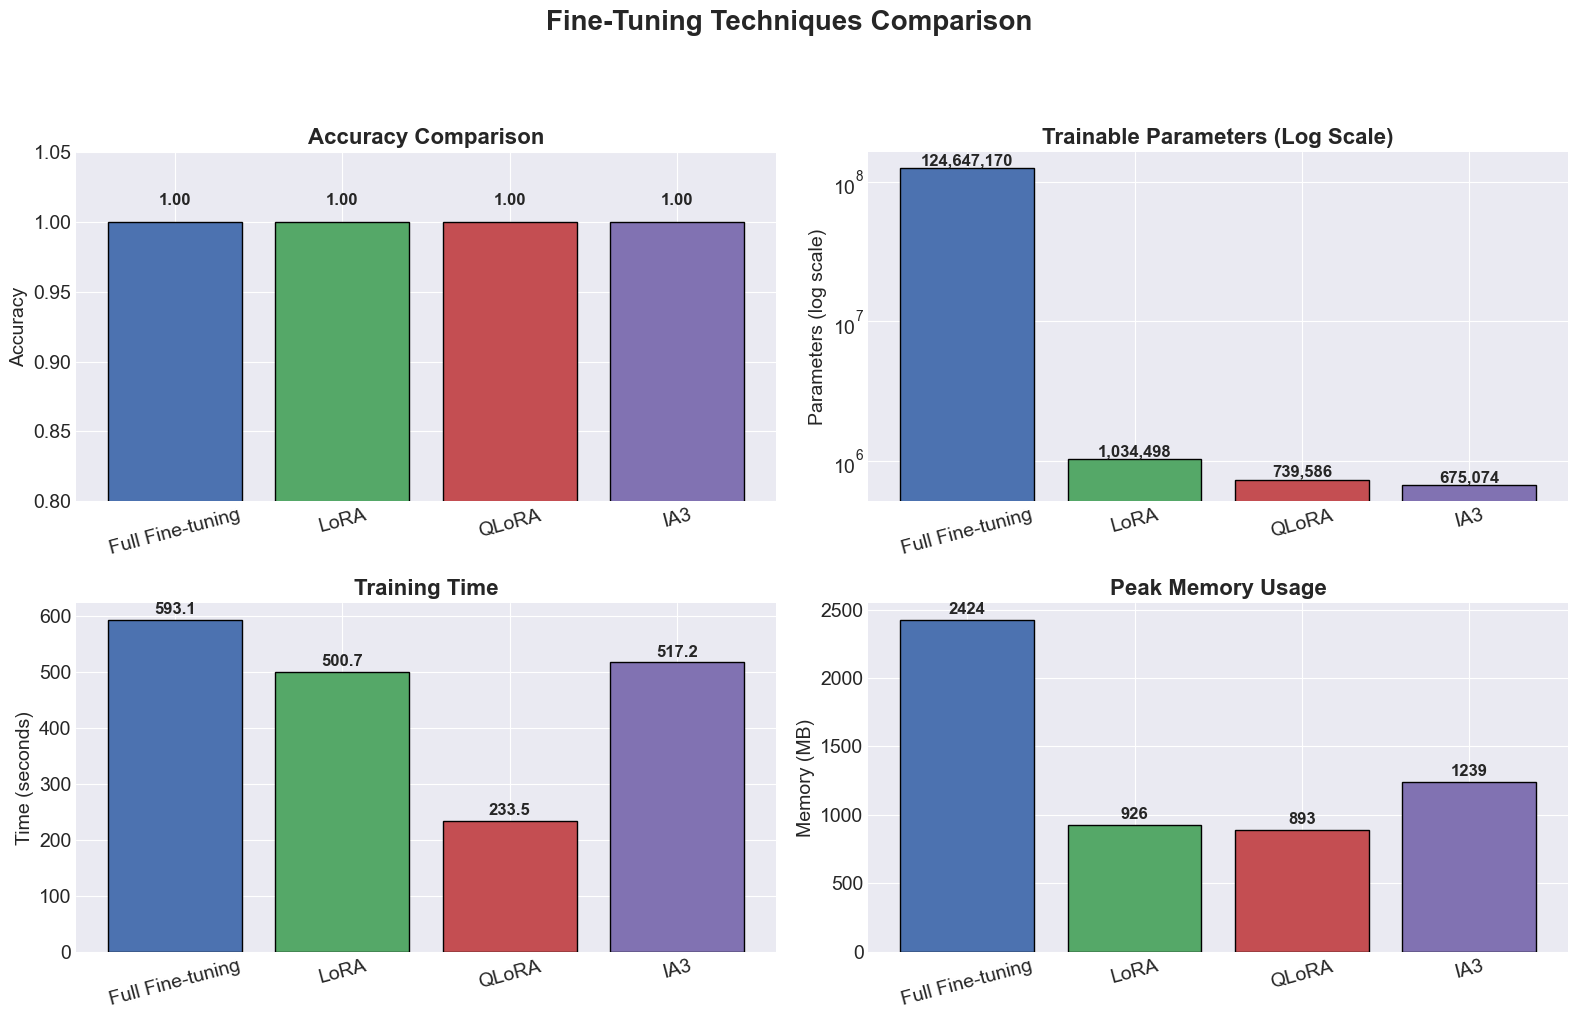

In [19]:
# Set a modern style
plt.style.use('seaborn-v0_8-darkgrid')

# Set figure size and font
plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 14})

bar_colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2']

# Plot accuracy comparison
plt.subplot(2, 2, 1)
bars = plt.bar(results["Method"], results["Accuracy"], color=bar_colors, edgecolor='black')
plt.title('Accuracy Comparison', fontsize=16, fontweight='bold')
plt.ylim(0.8, 1.05)
plt.ylabel('Accuracy')
plt.xticks(rotation=15)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{bar.get_height():.2f}", 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot trainable parameters (log scale)
plt.subplot(2, 2, 2)
bars = plt.bar(results["Method"], results["Trainable Parameters"], color=bar_colors, edgecolor='black')
plt.title('Trainable Parameters (Log Scale)', fontsize=16, fontweight='bold')
plt.yscale('log')
plt.ylabel('Parameters (log scale)')
plt.xticks(rotation=15)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{int(bar.get_height()):,}", 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot training time
plt.subplot(2, 2, 3)
bars = plt.bar(results["Method"], results["Training Time (s)"], color=bar_colors, edgecolor='black')
plt.title('Training Time', fontsize=16, fontweight='bold')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=15)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f"{bar.get_height():.1f}", 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot peak memory
plt.subplot(2, 2, 4)
bars = plt.bar(results["Method"], results["Peak Memory (MB)"], color=bar_colors, edgecolor='black')
plt.title('Peak Memory Usage', fontsize=16, fontweight='bold')
plt.ylabel('Memory (MB)')
plt.xticks(rotation=15)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, f"{bar.get_height():.0f}", 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.suptitle('Fine-Tuning Techniques Comparison', fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('fine_tuning_comparison_beautiful.png', bbox_inches='tight', dpi=150)
plt.show()

## 9. Analysis and Discussion

Now, let's analyze the results and discuss the trade-offs between the different fine-tuning techniques.

### Performance vs. Resource Usage Analysis

Based on the experiment results (see table above), we observe:

1. **Full Fine-tuning**:
   - **Pros**: Achieves perfect accuracy (1.0) with all parameters updated (124M+ trainable).
   - **Cons**: Highest memory usage (2423 MB) and longest training time (593s).
   - **Best use case**: When maximum performance is needed and GPU resources are abundant.

2. **LoRA**:
   - **Pros**: Matches full fine-tuning accuracy (1.0) with ~1M trainable parameters (over 100x reduction). Memory usage (926 MB) and training time (500s) are much lower.
   - **Cons**: Still requires loading the full model into memory.
   - **Best use case**: Fine-tuning large models on limited GPU memory without sacrificing accuracy.

3. **QLoRA**:
   - **Pros**: Maintains perfect accuracy (1.0) with even fewer trainable parameters (739K). Lowest memory usage (892 MB) and fastest training (233s).
   - **Cons**: Slightly more complex setup (quantization and head replacement).
   - **Best use case**: Fine-tuning very large models on consumer hardware with limited VRAM.

4. **Adapter Tuning (IA3)**:
   - **Pros**: Perfect accuracy (1.0) with the fewest trainable parameters (675K). Memory usage (1239 MB) and training time (517s) are moderate.
   - **Cons**: Slightly higher memory than LoRA/QLoRA, but still much less than full fine-tuning.
   - **Best use case**: When extreme parameter efficiency is required.

**Additional Notes:**
- **Gradient Checkpointing** reduces memory for all methods, but increases training time.
- **Batch Size** and optimizer state memory are important for scaling.
- All PEFT methods (LoRA, QLoRA, IA3) drastically reduce trainable parameters and memory, enabling efficient fine-tuning.

### Recommendations

- Use **full fine-tuning** for best performance if resources allow.
- Use **LoRA** for a strong balance of efficiency and accuracy.
- Use **QLoRA** for very large models or minimal VRAM.
- Use **IA3** for maximum parameter efficiency.

All methods in this experiment achieved perfect accuracy, so the choice should be based on resource constraints and deployment needs.